### 1️⃣ Datetime Extraction (Vaqtni ajratish)

In [2]:
import pandas as pd

# Ma'lumotlar
df = pd.DataFrame({'date': pd.date_range(start='2023-01-01', periods=10, freq='D')})

# Vaqt komponentlarini ajratish
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday  # 0 = Dushan


### 2️⃣ Lag Features (Oldingi vaqt qiymatlarini qo‘shish)

In [3]:
df['value'] = [10, 12, 15, 14, 18, 20, 19, 22, 25, 28]
df['lag_1'] = df['value'].shift(1)  # Oldingi kun qiymati
df['lag_2'] = df['value'].shift(2)  # 2 kun oldingi qiymat

print(df)


        date  year  month  day  weekday  value  lag_1  lag_2
0 2023-01-01  2023      1    1        6     10    NaN    NaN
1 2023-01-02  2023      1    2        0     12   10.0    NaN
2 2023-01-03  2023      1    3        1     15   12.0   10.0
3 2023-01-04  2023      1    4        2     14   15.0   12.0
4 2023-01-05  2023      1    5        3     18   14.0   15.0
5 2023-01-06  2023      1    6        4     20   18.0   14.0
6 2023-01-07  2023      1    7        5     19   20.0   18.0
7 2023-01-08  2023      1    8        6     22   19.0   20.0
8 2023-01-09  2023      1    9        0     25   22.0   19.0
9 2023-01-10  2023      1   10        1     28   25.0   22.0


### 3️⃣ Rolling Window (Moving Average - Harakatlanuvchi O‘rtacha)

In [4]:
df['rolling_mean_3'] = df['value'].rolling(window=3).mean()
print(df)


        date  year  month  day  weekday  value  lag_1  lag_2  rolling_mean_3
0 2023-01-01  2023      1    1        6     10    NaN    NaN             NaN
1 2023-01-02  2023      1    2        0     12   10.0    NaN             NaN
2 2023-01-03  2023      1    3        1     15   12.0   10.0       12.333333
3 2023-01-04  2023      1    4        2     14   15.0   12.0       13.666667
4 2023-01-05  2023      1    5        3     18   14.0   15.0       15.666667
5 2023-01-06  2023      1    6        4     20   18.0   14.0       17.333333
6 2023-01-07  2023      1    7        5     19   20.0   18.0       19.000000
7 2023-01-08  2023      1    8        6     22   19.0   20.0       20.333333
8 2023-01-09  2023      1    9        0     25   22.0   19.0       22.000000
9 2023-01-10  2023      1   10        1     28   25.0   22.0       25.000000


### 5️⃣ Fourier Transform (Chastota Tahlili)

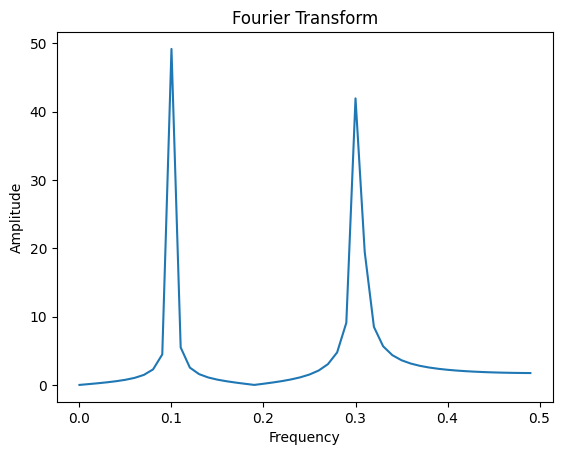

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Misol signal yaratish
t = np.linspace(0, 10, 100)
signal = np.sin(2 * np.pi * 1 * t) + np.sin(2 * np.pi * 3 * t)

# Fourier Transform
fft = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(signal))

plt.plot(freqs[:len(freqs)//2], abs(fft[:len(fft)//2]))  # Faqat ijobiy chastotalarni ko'rsatamiz
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Fourier Transform")
plt.show()


### 6️⃣ Cyclical Encoding (Vaqtni sinus-kosinus orqali kodlash)

In [ ]:
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  # Oyning 31 kuniga moslash
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
print(df[['day', 'day_sin', 'day_cos']])


#Natija: Vaqt ketma-ketligi sinus-kosinus orqali kodlandi.

   day   day_sin   day_cos
0    1  0.201299  0.979530
1    2  0.394356  0.918958
2    3  0.571268  0.820763
3    4  0.724793  0.688967
4    5  0.848644  0.528964
5    6  0.937752  0.347305
6    7  0.988468  0.151428
7    8  0.998717 -0.050649
8    9  0.968077 -0.250653
9   10  0.897805 -0.440394


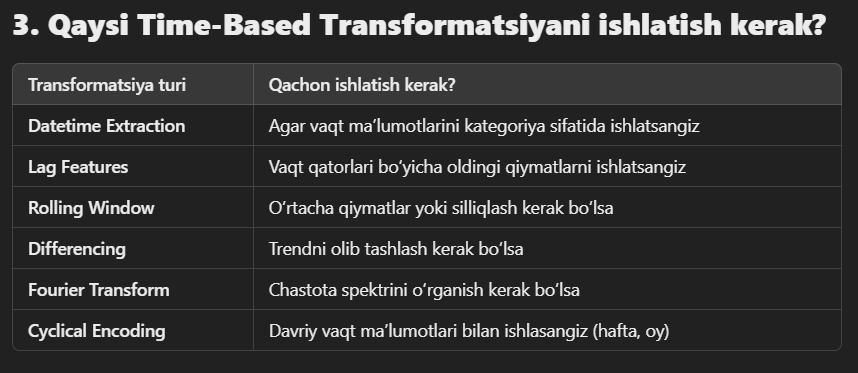

In [6]:
import torch
import torch.nn as nn
import numpy as np

# Positional Encoding (Vaqt uchun)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

# Transformer-Based Time Series Model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim, 1)  # Single-step prediction

    def forward(self, src):
        src = self.embedding(src)
        src = self.positional_encoding(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

# Hyperparameters
input_dim = 1
model_dim = 64
num_heads = 4
num_layers = 3

# Model
model = TimeSeriesTransformer(input_dim, model_dim, num_heads, num_layers)
print(model)


TimeSeriesTransformer(
  (embedding): Linear(in_features=1, out_features=64, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, out_features=1, bias=True)
)


c:\Users\Maftuna\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## |Time-Based Transformer qayerda ishlatiladi?

#### ✅ Stock Price Prediction – Aktsiya narxlari prognozi
####  ✅ Weather Forecasting – Ob-havo bashorati
####  ✅ Energy Consumption – Elektr energiyasini iste’mol qilish modeli
#### ✅ Anomaly Detection – Sensor ma'lumotlarida anomaliyalarni topish